<a href="https://colab.research.google.com/github/mella30/Deep-Learning-with-Tensorflow-2/blob/main/Course2-Customising_your_models_with_Tensorflow_2/week4_subclassing_custom_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [ ]:
# Build the model
# One branch has only the dense one layer, the other has the dense two, a dense three layers sequentially.
# Then the outputs of both branches can be concatenated by just writing concatenate. 

class MyModel(Model):

  def __init__(self):
    super(MyModel, self).__init__()

    self.dense_1 = Dense(64, activation='relu')
    self.dense_2 = Dense(10)
    self.dense_3 = Dense(5)
    self.softmax = Softmax()

  def call(self, inputs, training=True):
    x = self.dense_1(inputs)
    y1 = self.dense_2(inputs)
    y2 = self.dense_3(y1)
    concat = concatenate([x,y2])
    return self.softmax(concat)

In [ ]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([1,10]))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  704       
_________________________________________________________________
dense_1 (Dense)              multiple                  110       
_________________________________________________________________
dense_2 (Dense)              multiple                  55        
_________________________________________________________________
softmax (Softmax)            multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [ ]:
# Create a custom layer

class MyLayer(Layer):

  def __init__(self, units, input_dim):
    super(MyLayer, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units),
                             initializer='random_normal')
    self.b = self.add_weight(shape=(units,),
                             initializer='zeros')
    
  def call(self, inputs):
    return tf.matmul(inputs, self.w)+self.b

dense_layer = MyLayer(3,5)
x = tf.ones((1,5))
print(dense_layer(x))
print(dense_layer.weights)

tf.Tensor([[ 0.03809061  0.15602739 -0.11207093]], shape=(1, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[-0.11872357,  0.04890529, -0.02663227],
       [ 0.03091317,  0.02336162, -0.08939604],
       [ 0.08055347,  0.11619683, -0.02668897],
       [ 0.05359671, -0.02418938,  0.03706935],
       [-0.00824917, -0.00824697, -0.006423  ]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [ ]:
# Specify trainable weights (to freeze parts of the layers weights) 

class MyLayerNontrainable(Layer):

  def __init__(self, units, input_dim):
    super(MyLayerNontrainable, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units),
                             initializer='random_normal',
                             trainable=False)
    self.b = self.add_weight(shape=(units,),
                             initializer='zeros',
                             trainable=False)
    
  def call(self, inputs):
    return tf.matmul(inputs, self.w)+self.b

dense_layer_nontrainable = MyLayerNontrainable(3,5)

In [ ]:
print('trainable weights:', len(dense_layer_nontrainable.trainable_weights))
print('non-trainable weights:', len(dense_layer_nontrainable.non_trainable_weights))

trainable weights: 0
non-trainable weights: 2


In [ ]:
# Create a custom layer to accumulate means of output values
# 

class MyLayerMean(Layer):

  def __init__(self, units, input_dim):
    super(MyLayerMean, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units),
                             initializer='random_normal')
    self.b = self.add_weight(shape=(units,),
                             initializer='zeros')
    # accumulate means of output values everytime it is called
    self.sum_activation = tf.Variable(initial_value=tf.zeros((units,)),
                                      trainable=False)
    # counts the number of times the layer has been called
    self.number_call = tf.Variable(initial_value=0,
                                   trainable=False)
    
  def call(self, inputs):
    # activation of the outputs
    activations = tf.matmul(inputs, self.w)+self.b
    # update values (sum and number of calls, will keep their values across calls) 
    self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
    self.number_call.assign_add(inputs.shape[0])
    return activations, self.sum_activation / tf.cast(self.number_call, tf.float32)

dense_layer_mean = MyLayerMean(3,5)

In [ ]:
# Test the layer

y, activation_means = dense_layer_mean(tf.ones((1, 5)))
print(activation_means.numpy())

# nothing changes because weights and bias are not updated
y, activation_means = dense_layer_mean(tf.ones((1, 5)))
print(activation_means.numpy())
# Accumulating the mean or variance of the activations can be really useful e.g. for analyzing the propagation of signals in the network. 

[-0.03866848  0.03801265 -0.01571291]
[-0.03866848  0.03801265 -0.01571291]


In [ ]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

#### Implement the custom layers into a model

In [ ]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)  # call activations here, otherwise the layers will be linear
        x = self.dropout_1(x)
        x = self.layer_2(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)

        return self.softmax(x)

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

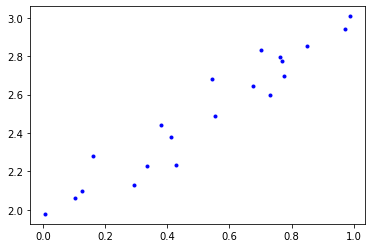

In [3]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [6]:
from tensorflow.keras.layers import Layer

In [9]:
# Build a custom layer for the linear regression model

class LinearLayer(Layer):

  def __init__(self):
    super(LinearLayer, self).__init__()
    self.m = self.add_weight(shape=(1,),
                             initializer='random_normal')
    self.b = self.add_weight(shape=(1,),
                             initializer='zeros')
    
  def call(self, inputs):
    return self.m*inputs+self.b

linear_regression = LinearLayer()

print(linear_regression(x_train))
print(linear_regression.weights)

tf.Tensor(
[0.06933199 0.023721   0.07912418 0.03079096 0.04425802 0.01021458
 0.04513784 0.0005613  0.06225901 0.06271388 0.00839703 0.03471534
 0.02714759 0.06329098 0.08046802 0.05948634 0.03361373 0.01292873
 0.05710317 0.05492993], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.08147576], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


#### Define the loss function

In [10]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.1552916


#### Train and plot the model

In [12]:
# Implement a gradient descent training loop for the linear regression model

learning_rate = 0.05
steps = 25

for i in range(steps):
  with tf.GradientTape() as tape:
    predictions = linear_regression(x_train)
    loss = SquaredError(predictions, y_train)

  gradients = tape.gradient(loss, linear_regression.trainable_variables)

  linear_regression.m.assign_sub(learning_rate * gradients[0])
  linear_regression.b.assign_sub(learning_rate * gradients[0])

  print("Step %d, Loss %f" % (i, loss.numpy()))

Step 0, Loss 6.155292
Step 1, Loss 5.140264
Step 2, Loss 4.295762
Step 3, Loss 3.592967
Step 4, Loss 3.007949
Step 5, Loss 2.520832
Step 6, Loss 2.115104
Step 7, Loss 1.777052
Step 8, Loss 1.495284
Step 9, Loss 1.260334
Step 10, Loss 1.064337
Step 11, Loss 0.900758
Step 12, Loss 0.764163
Step 13, Loss 0.650038
Step 14, Loss 0.554628
Step 15, Loss 0.474813
Step 16, Loss 0.407995
Step 17, Loss 0.352016
Step 18, Loss 0.305078
Step 19, Loss 0.265688
Step 20, Loss 0.232598
Step 21, Loss 0.204775
Step 22, Loss 0.181353
Step 23, Loss 0.161614
Step 24, Loss 0.144958


m:1,  trained m:[1.4811265]
b:2,  trained b:[1.3996508]


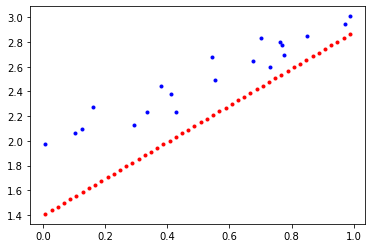

In [13]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [ ]:
# Define the custom layers and model



#### Load the reuters dataset and define the class_names 

In [ ]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [ ]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

#### Get the dataset word index

In [ ]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

In [ ]:
# Print the first data example sentence



#### Preprocess the data

In [ ]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

#### Define the loss function and optimizer



In [ ]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [ ]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

    
    
print("Duration :{:.3f}".format(time.time() - start_time))

#### Evaluate the model

In [ ]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [ ]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [ ]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

#### Plot the learning curves

In [ ]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [ ]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [ ]:
# Initialize a new model



#### Redefine the grad function using the @tf.function decorator

In [ ]:
# Use the @tf.function decorator



#### Train the model

In [ ]:
# Re-run the training loop



#### Print the autograph code

In [ ]:
# Use tf.autograph.to_code to see the generated code

